### Embedding visualization

In [46]:
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from data import get_dataset, get_zoo_elephants_images_and_labels, get_ELEP_images_and_labels
from tensorflow.keras import optimizers
from sklearn.preprocessing import OrdinalEncoder
from train import SiameseModel
import json
from metrics import get_kernel_mask, val, far, pairwise_accuracy

In [16]:
data_dir = '/Users/gandhalimarunmale/Documents/02_Sem/Computer Vision/cv-project/siamese/Elephants-dataset-cropped-png-1024'

In [17]:
params = {
    'image_size': 256,
    'resize_pad': False,
    'dense_l2_reg_c': 0.0001,
    'embedding_size': 1,
    'lr': 0.001
}


#### Train images without augmentation on base model ResrNet50 weights

In [18]:
train_ds, N_train = get_dataset(get_zoo_elephants_images_and_labels, 
                                params, 
                                str(Path(data_dir)/'part1'),
                                augment=False,  
                                cache_file=None, 
                                shuffle=False,
                                batch_size=32)

In [19]:
image_paths, image_labels = get_zoo_elephants_images_and_labels(str(Path(data_dir)/'part1'))

In [20]:
enc = OrdinalEncoder()
l= np.array(image_labels).reshape(-1, 1)
enc.fit(l)
categories = enc.transform(l)

In [52]:
# image_paths, image_labels = get_zoo_elephants_images_and_labels(str(Path(data_dir)/'train'))
# y_true = (np.array(image_labels) == 'elephants').astype(np.int32)

In [72]:
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights="imagenet", input_shape=(
        params['image_size'], params['image_size'], 3), pooling='avg')
embeddings = base_model.predict(train_ds)

In [73]:
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=1)

In [74]:
embeddings.shape

(634, 2048)

In [251]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(embeddings)

In [170]:
means = np.zeros((7, 2))
for c in range(7):
    rix = np.where(categories == c)[0]
    mean = np.mean(X_embedded[rix, :], axis=0)
    means[c, :] = mean

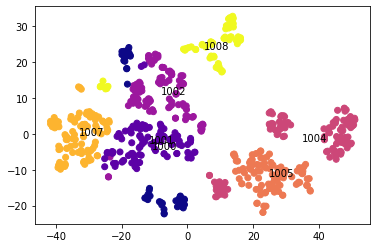

In [175]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=categories, cmap='plasma')
for i in range(7):
    plt.annotate(enc.categories_[0][i], (means[i, 0], means[i,1]))

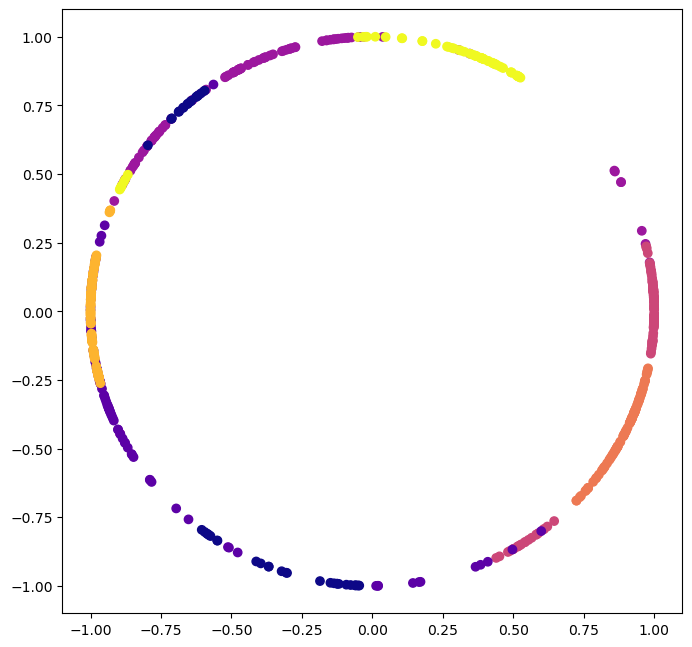

In [243]:
X_embedded_norm = X_embedded / np.linalg.norm(X_embedded, axis=1, keepdims=1)
plt.figure(figsize=(8, 8), dpi=100)
plt.scatter(X_embedded_norm[:,0], X_embedded_norm[:,1], c=categories, cmap='plasma')

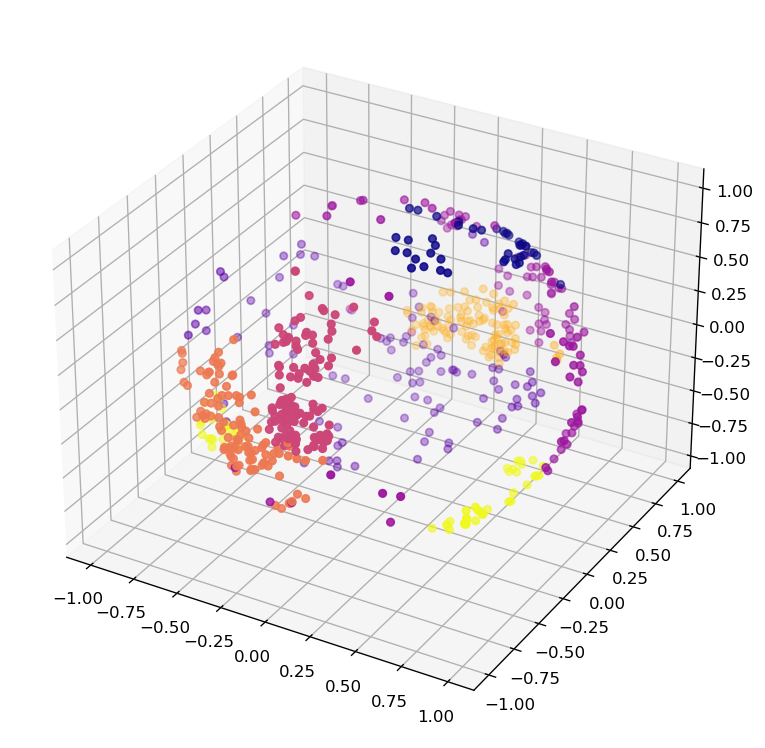

In [253]:
X_embedded_norm = X_embedded / np.linalg.norm(X_embedded, axis=1, keepdims=1)
fig = plt.figure(figsize=(8,8), dpi=120)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_embedded_norm[:,0], X_embedded_norm[:,1], X_embedded_norm[:,2], c = categories, marker='o', cmap='plasma')

In [ ]:
kernel, mask = get_kernel_mask(l, embeddings)

In [ ]:
plt.imshow(mask)

In [ ]:
enc.categories_[0]

In [ ]:
l[550]

In [ ]:
np.where(categories == 2)[0]

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow((kernel < 0.5) * (mask))

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(kernel[:, :] < 0.5)

#### Train images without augmentation on base model InceptionV3 weights

In [25]:
base_model_inc = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_shape=(
        params['image_size'], params['image_size'], 3), pooling='avg')
embeddings_inc = base_model_inc.predict(train_ds)

In [40]:
embeddings_inc = embeddings_inc / np.linalg.norm(embeddings_inc, axis=1, keepdims=1)

In [41]:
from sklearn.manifold import TSNE
X_embedded_inc = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(embeddings_inc)

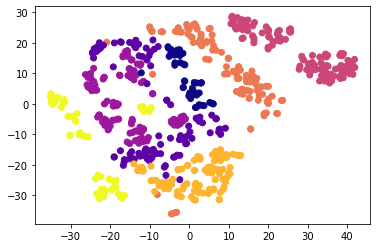

In [42]:
plt.scatter(X_embedded_inc[:,0], X_embedded_inc[:,1], c=categories, cmap='plasma')

#### Train images without augmentation on learned weights for ResNet50

In [31]:
!pwd

/Users/gandhalimarunmale/Documents/02_Sem/Computer Vision/cv-project/siamese


In [29]:
with open('hyperparameters/initial_run.json', 'rb') as f:
        params_siamese = json.load(f)

In [30]:
params_siamese

{'name': 'init',
 'image_size': 256,
 'resize_pad': False,
 'batch_size': {'train': 128, 'val': 512},
 'margin': 0.5,
 'squared': False,
 'embedding_size': 256,
 'lr': 5e-05,
 'decay_steps': 13,
 'decay_rate': 0.96,
 'dense_l2_reg_c': 0.01,
 'metrics_d': 1.25,
 'triplet_strategy': 'batch_all',
 'depthwise': False}

In [31]:
siamese_model = SiameseModel(params_siamese, False)

In [32]:
siamese_model.load_weights('best_weights')

In [42]:
siamese_model.summary()

Model: "siamese_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 256)               24089344  
                                                                 
Total params: 24,089,350
Trainable params: 524,544
Non-trainable params: 23,564,806
_________________________________________________________________


In [33]:
embeddings_siamese = siamese_model.predict(train_ds)

In [43]:
embeddings_siamese = embeddings_siamese / np.linalg.norm(embeddings_siamese, axis=1, keepdims=1)

In [246]:
X_embedded_siamese = TSNE(n_components=3,
                          learning_rate='auto', 
                          init='random').fit_transform(embeddings_siamese)

In [247]:
X_embedded_siamese_norm = X_embedded_siamese / np.linalg.norm(X_embedded_siamese, axis=1, keepdims=1)

In [241]:
means_siamese = np.zeros((7, 2))
for c in range(7):
    rix = np.where(categories == c)[0]
    mean = np.mean(X_embedded_siamese_norm[rix, :], axis=0)
    means_siamese[c, :] = mean

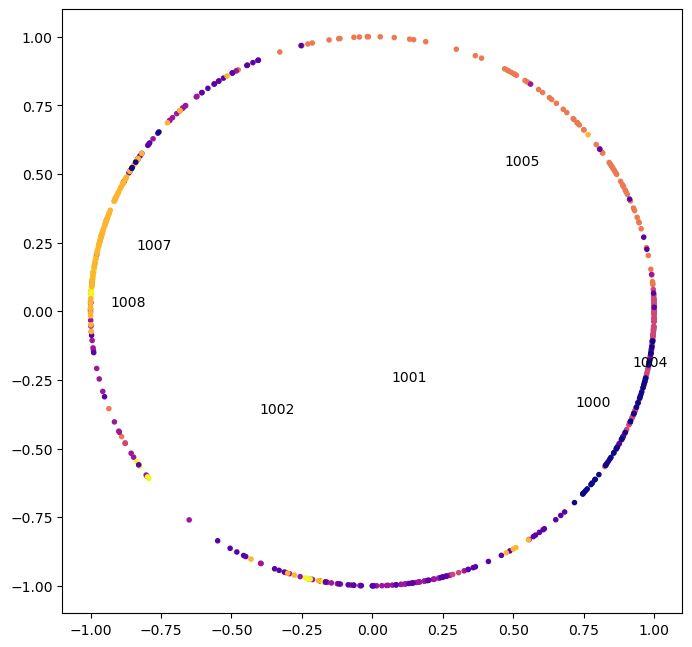

In [245]:
plt.figure(figsize=(8, 8), dpi=100)
plt.scatter(X_embedded_siamese_norm[:,0], X_embedded_siamese_norm[:,1], c=categories, cmap='plasma', marker='.')
for i in range(7):
    plt.annotate(enc.categories_[0][i], (means_siamese[i, 0], means_siamese[i,1]))

In [261]:
!jupyter labextension install jupyter-matplotlib@0.3.0

Building jupyterlab assets (production, minimized)


In [ ]:
!pip install ipympl==0.7

In [274]:
%matplotlib notebook

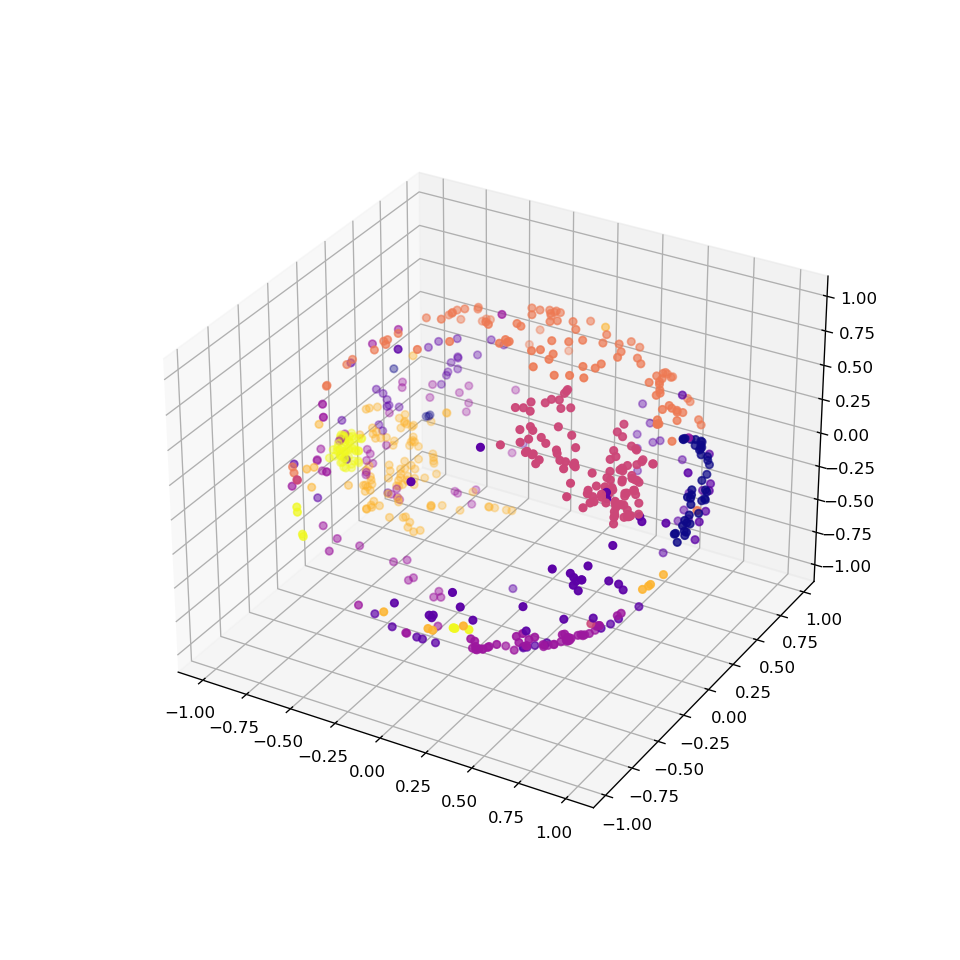

In [270]:
fig = plt.figure(figsize=(8,8), dpi=120)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_embedded_siamese_norm[:,0], X_embedded_siamese_norm[:,1], X_embedded_siamese_norm[:,2], c = categories, marker='o', cmap='plasma')

In [219]:
kernel_s, mask_s = get_kernel_mask(l, embeddings_siamese)

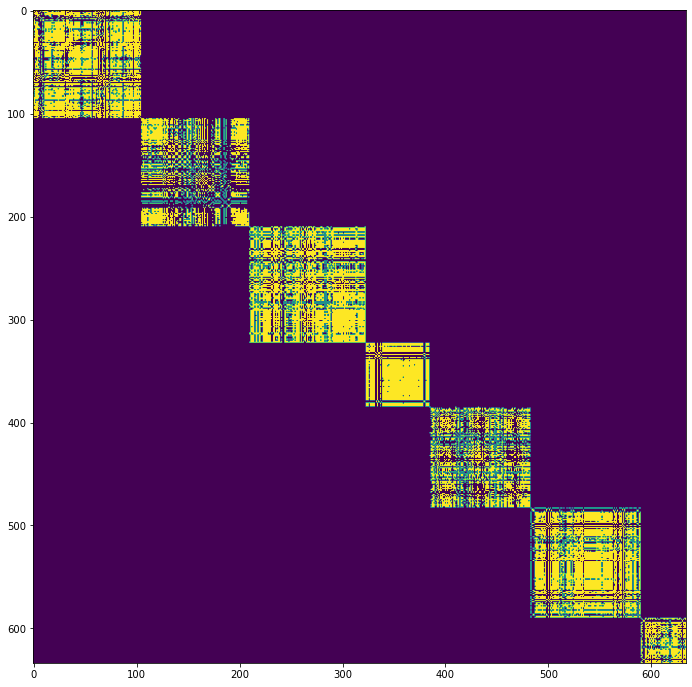

In [227]:
plt.figure(figsize=(12,12))
plt.imshow((kernel_s < 0.8) * (mask_s))

In [256]:
np.rad2deg(np.arccos(1-0.8*0.8/2))

47.15635695640367

In [70]:
from sklearn.manifold import MDS

In [76]:
mds = MDS(n_components=2)
mds_base = mds.fit_transform(embeddings)
mds_base.shape

(634, 2)

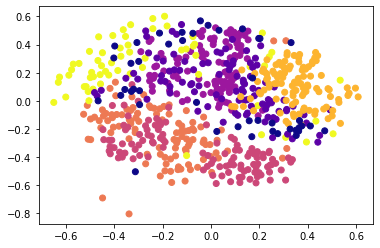

In [77]:
plt.scatter(mds_base[:,0], mds_base[:,1], c=categories, cmap='plasma')

In [78]:
mds = MDS(n_components=2)
mds_inc = mds.fit_transform(embeddings_inc)
mds_inc.shape

(634, 2)

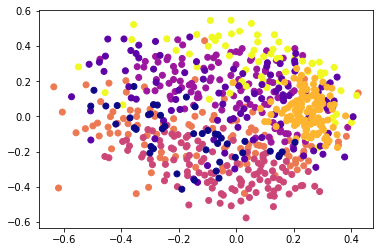

In [79]:
plt.scatter(mds_inc[:,0], mds_inc[:,1], c=categories, cmap='plasma')

In [272]:
mds = MDS(n_components=3)
mds_siamese = mds.fit_transform(embeddings_siamese)
mds_siamese.shape

(634, 3)

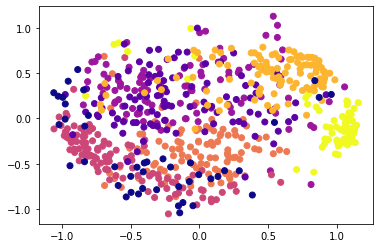

In [81]:
plt.scatter(mds_siamese[:,0], mds_siamese[:,1], c=categories, cmap='plasma')

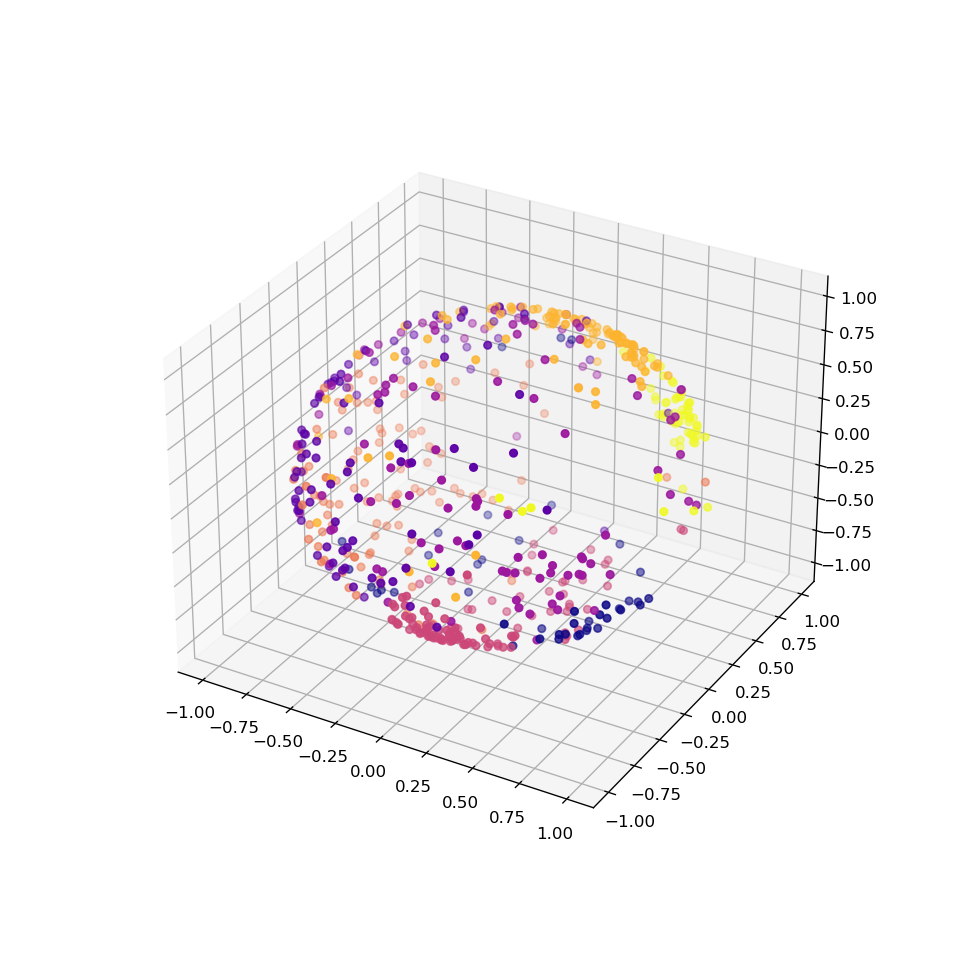

In [275]:
mds_siamese_norm = mds_siamese / np.linalg.norm(mds_siamese, axis=1, keepdims=1)
fig = plt.figure(figsize=(8,8), dpi=120)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mds_siamese_norm[:,0], mds_siamese_norm[:,1], mds_siamese_norm[:,2], c = categories, marker='o', cmap='plasma')

In [82]:
from sklearn.manifold import SpectralEmbedding

In [83]:
se = SpectralEmbedding(n_components=2)
se_base = se.fit_transform(embeddings)
se_base.shape

(634, 2)

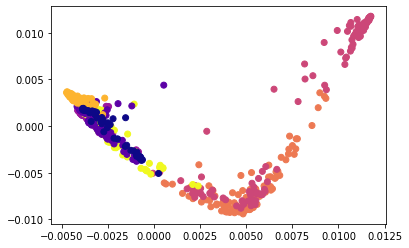

In [84]:
plt.scatter(se_base[:,0], se_base[:,1], c=categories, cmap='plasma')

In [102]:
se = SpectralEmbedding(n_components=2)
se_inc = se.fit_transform(embeddings_inc)
se_inc.shape

(634, 2)

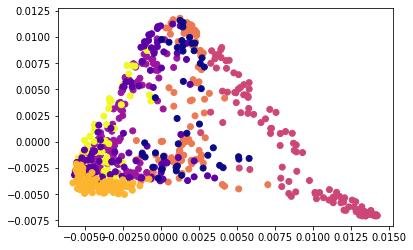

In [103]:
plt.scatter(se_inc[:,0], se_inc[:,1], c=categories, cmap='plasma')

In [104]:
se = SpectralEmbedding(n_components=2)
se_siamese = se.fit_transform(embeddings_siamese)
se_siamese.shape

(634, 2)

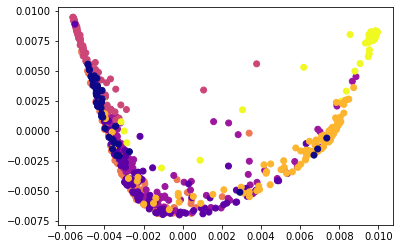

In [105]:
plt.scatter(se_siamese[:,0], se_siamese[:,1], c=categories, cmap='plasma')

In [89]:
from sklearn.manifold import LocallyLinearEmbedding

In [129]:
lle = LocallyLinearEmbedding(n_components=2)
lle_base = lle.fit_transform(embeddings)
lle_base.shape

(634, 2)

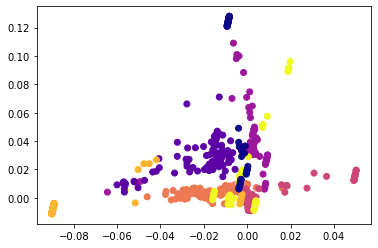

In [130]:
plt.scatter(lle_base[:,0], lle_base[:,1], c=categories, cmap='plasma')

In [131]:
lle = LocallyLinearEmbedding(n_components=2, method='standard')#‘hessian’, ‘modified’, ‘ltsa’
lle_siamese = lle.fit_transform(embeddings_siamese)
lle_siamese.shape

(634, 2)

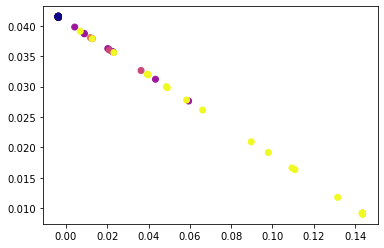

In [132]:
plt.scatter(lle_siamese[:,0], lle_siamese[:,1], c=categories, cmap='plasma')

In [47]:
def get_metrics(embeddings, labels, d):
    kernel, mask = get_kernel_mask(labels, embeddings)
    return val(kernel, mask, d), far(kernel, mask, d), pairwise_accuracy(kernel, mask, d)
    

In [62]:
for d in np.arange(0.1, 1.3, 0.1):
    print(np.round(d, 2), np.round(get_metrics(embeddings, l, d), 3))

0.1 [0.    0.    0.848]
0.2 [0.009 0.    0.849]
0.3 [0.044 0.    0.855]
0.4 [0.223 0.015 0.869]
0.5 [0.583 0.126 0.83 ]
0.6 [0.87  0.472 0.58 ]
0.7 [0.986 0.848 0.279]
0.8 [0.996 0.982 0.167]
0.9 [1.    0.996 0.156]
1.0 [1.    0.999 0.153]
1.1 [1.    1.    0.152]
1.2 [1.    1.    0.152]


In [67]:
for d in np.arange(0.1, 1.3, 0.1):
    print(np.round(d, 2), np.round(get_metrics(embeddings_inc, l, d), 3))

0.1 [0.    0.    0.848]
0.2 [0.016 0.    0.85 ]
0.3 [0.17  0.01  0.865]
0.4 [0.509 0.165 0.786]
0.5 [0.809 0.565 0.492]
0.6 [0.949 0.872 0.252]
0.7 [0.989 0.976 0.17 ]
0.8 [0.999 0.998 0.154]
0.9 [1.    1.    0.152]
1.0 [1.    1.    0.152]
1.1 [1.    1.    0.152]
1.2 [1.    1.    0.152]


In [64]:
for d in np.arange(0.1, 1.3, 0.1):
    print(np.round(d, 2), np.round(get_metrics(embeddings_siamese, l, d), 3))

0.1 [0.    0.    0.848]
0.2 [0.005 0.    0.849]
0.3 [0.024 0.    0.852]
0.4 [0.074 0.001 0.859]
0.5 [0.181 0.008 0.869]
0.6 [0.329 0.032 0.871]
0.7 [0.485 0.083 0.851]
0.8 [0.621 0.164 0.803]
0.9 [0.737 0.27  0.732]
1.0 [0.823 0.387 0.645]
1.1 [0.885 0.506 0.553]
1.2 [0.93  0.622 0.462]


#### Train images without augmentation on base model InceptionV3 weights

In [25]:
base_model_inc = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_shape=(
        params['image_size'], params['image_size'], 3), pooling='avg')
embeddings_inc = base_model_inc.predict(train_ds)

87924736/87910968 [==============================] - 12s 0us/step


In [26]:
from sklearn.manifold import TSNE
X_embedded_inc = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(embeddings_inc)

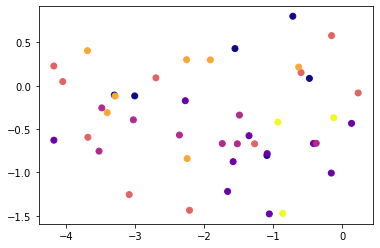

In [28]:
plt.scatter(X_embedded_inc[:,0], X_embedded_inc[:,1], c=categories, cmap='plasma')

## Images with resizepad

In [50]:
params = {
    'image_size': 256,
    'resize_pad': True,
    'dense_l2_reg_c': 0.0001,
    'embedding_size': 1,
    'lr': 0.001
}

cache_files = {
        'train': str(Path(data_dir) / 'train_resize.cache'),
        'val': str(Path(data_dir) / 'val_resize.cache')
}

In [51]:
train_ds, N_train = get_dataset(get_zoo_elephants_images_and_labels, 
                                params, 
                                str(Path(data_dir)/'train'),
                                augment=True,  
                                cache_file=cache_files['train'], 
                                shuffle=True,
                                batch_size=32)

val_ds, N_val = get_dataset(get_zoo_elephants_images_and_labels, 
                            params, 
                            str(Path(data_dir)/'val'),
                            augment=False, 
                            cache_file=cache_files['val'], 
                            shuffle=False, 
                            batch_size=32)

train_ds = train_ds.map(lambda x, y: (x, tf.cast(y == b'elephants', tf.int32)),
        num_parallel_calls=tf.data.AUTOTUNE)

val_ds = val_ds.map(lambda x, y: (x, tf.cast(y == b'elephants', tf.int32)),
        num_parallel_calls=tf.data.AUTOTUNE)